In [1]:
import numpy as np
import matplotlib.pyplot as plt

### ALIF neuron dynamics

In [105]:
# specify some constants
dt = 1. # timestep
t_mem = 20 # membrane time constant
t_thr = 700 # threshold time constant
beta = 1.8 # threshold update constant of ALIF neuron
t0 = 0 # initial time
n_timestep = 100 # number of simulated time step
v0 = 0. # initial membrane voltage
thr0 = 0.01 # initial membrane threshold
thr_static = thr0 # the baseline threshold
n_refractory = 3 # number of refractory timestep


In [106]:
# threshold update function
def update_thr(thr_static, thr_pre, beta, t_thr, dt, z_rec):
    '''Return the membrane threshold'''
    rou = np.exp(-dt/t_thr)
    return thr_static + beta * (rou*thr_pre + (1-rou)*z_rec)


#　voltage update function
def update_voltage(v_pre, dt, t_mem, z_pre, z_rec, w_in, w_rec):
    '''Return the voltage of neuron for the next time step'''
    alpha = np.exp(-dt/t_mem)
    I_pre = w_in * z_pre + w_rec * z_rec
    return alpha * v_pre + (1-alpha) * I_pre


In [107]:
# main
ts = t0 + np.linspace(1, n_timestep*dt, num=n_timestep).astype(int) - 1
vs = v0 * np.ones(len(ts)+1)
thrs = thr0 * np.ones(len(ts)+1)
#z_pre = np.ones(len(ts))
#z_pre = np.concatenate((np.ones(50), np.zeros(len(ts) - 50)))
z_pre = np.zeros(len(ts))
index_rand_pre = np.random.randint(0, 100, 30)
for index in index_rand_pre:
    z_pre[index] = 1
z_rec = np.zeros(len(ts)+1)
w_in = 0.5
w_rec = 0.5

i = 0
while i < len(ts):
    if vs[i] > thrs[i]: # emit a spike at next time step
        z_rec[i] = 1
        if i + n_refractory < 100:
            for j in np.arange(n_refractory):
                thrs[i+j+1] = update_thr(thr_static, (thrs[i+j]-thr0)/beta, beta, t_thr, dt, z_rec[i+j])
                #print(i+j)
        i += n_refractory

    else:
        # update vs and thrs for the next time step
        #print(str(i) + " no spike")
        vs[i+1] = update_voltage(vs[i], dt, t_mem, z_pre[i], z_rec[i], w_in, w_rec)
        thrs[i+1] = update_thr(thr_static, (thrs[i]-thr0)/beta, beta, t_thr, dt, z_rec[i])
        i += 1



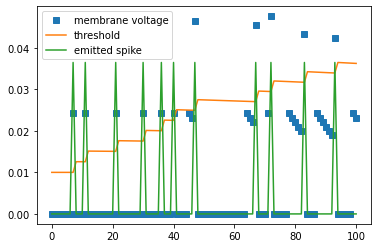

In [108]:
plt.plot(np.arange(0,len(vs), 1, dtype=int), vs, 's', label = 'membrane voltage')
plt.plot(np.arange(0,len(thrs), 1, dtype=int), thrs, label = 'threshold')
plt.plot(np.arange(0,len(z_rec), 1, dtype=int), max(thrs)*np.array(z_rec), label = 'emitted spike')
#plt.xlim(0, 20)
plt.legend()
plt.show()

### STDP + ALIF

In [109]:
def Modified_STDP_weight_update(G_min, G_max, current_weight, 
                       alpha_p, alpha_m, beta_p, beta_m, potentiation = 1):
    
    '''
    Inputs:
        ratio: true_update_ratio/calculated_update_ratio by exponential funcion
        G_min: minimum conductance of a device
        G_max: maximum conductance of a device
        current_weight: current weight matrix
        alpha_p: alpha index for potentiation
        alpha_m: alpha index for depression 
        beta_p: beta index for potentiation
        beta_m: beta index for depression
        t1: fired time of pre-synaptic neuron
        t2: fired time of post-synaptic neuron
    Return:
        updated_weights
    '''
    if potentiation == 1: # for the case of potentiation
        delta_weight = alpha_p * np.exp(-beta_p*(current_weight-G_min)/(G_max-G_min))
        updated_weight = current_weight + delta_weight

    elif potentiation == 0: # for the case of depression
        delta_weight = -alpha_m * np.exp(-beta_m*(G_max-current_weight)/(G_max-G_min))
        updated_weight = current_weight + delta_weight
    else:
        raise ValueError("Parameter potentiation must be 0 or 1!")

    return updated_weight

    

In [110]:
# calculate the change of weight/conductance with respect to z_pre and z_rec
def update_weight(w_in, z_pre, z_rec, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m):
    '''For arbitrary spike trains - z_pre and z_rec, update the weight''' 
    assert (len(z_pre) == len(z_rec)), "two input spike trains should have the same length."
    w_in_history = []
    for i in range(len(z_pre)-1):
        if z_pre[i] != 0:
            if z_rec[i-1] != 0: #　depression
                w_in = Modified_STDP_weight_update(G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 0)
            elif z_rec[i+1] != 0: # potentiation
                w_in = Modified_STDP_weight_update(G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 1)
        w_in_history.append(w_in)
    return w_in_history

In [111]:
# memtransistor parameters
G_min = 0.0001
G_max = 1.0
alpha_p = 0.01
alpha_m = 0.005
beta_p = 3.
beta_m = 3.

w_in_history = update_weight(w_in, z_pre, z_rec[:len(z_rec)-1], G_min, G_max, alpha_p, alpha_m, beta_p, beta_m)

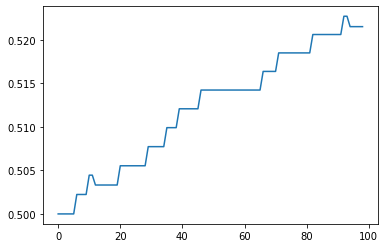

In [112]:
# the change of w_in with respect to time
plt.plot(np.arange(0,len(w_in_history), 1, dtype=int), w_in_history)
plt.show()

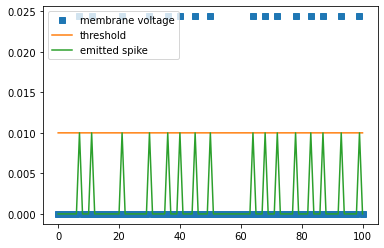

In [113]:
# specify some constants for LIF neuron
beta = 1e-5 # threshold update constant of ALIF neuron

# main for LIF neuron
vs = v0 * np.ones(len(ts)+1)
thrs = thr0 * np.ones(len(ts)+1)
z_rec = np.zeros(len(ts)+1)
w_in = 0.5
w_rec = 0.5

i = 0
while i < len(ts):
    if vs[i] > thrs[i]: # emit a spike at next time step
        z_rec[i] = 1
        if i + n_refractory < 100:
            for j in np.arange(n_refractory):
                thrs[i+j+1] = update_thr(thr_static, (thrs[i+j]-thr0)/beta, beta, t_thr, dt, z_rec[i+j])
                #print(i+j)
        i += n_refractory

    else:
        # update vs and thrs for the next time step
        #print(str(i) + " no spike")
        vs[i+1] = update_voltage(vs[i], dt, t_mem, z_pre[i], z_rec[i], w_in, w_rec)
        thrs[i+1] = update_thr(thr_static, (thrs[i]-thr0)/beta, beta, t_thr, dt, z_rec[i])
        i += 1

plt.plot(np.arange(0,len(vs), 1, dtype=int), vs, 's', label = 'membrane voltage')
plt.plot(np.arange(0,len(thrs), 1, dtype=int), thrs, label = 'threshold')
plt.plot(np.arange(0,len(z_rec), 1, dtype=int), max(thrs)*np.array(z_rec), label = 'emitted spike')
#plt.xlim(0, 20)
plt.legend()
plt.show()

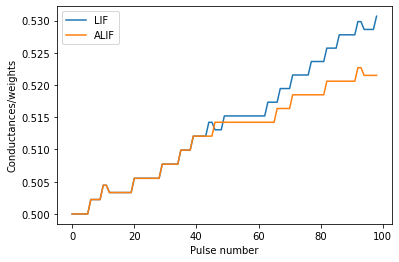

In [114]:
# memtransistor parameters
G_min = 0.0001
G_max = 1.0
alpha_p = 0.01
alpha_m = 0.005
beta_p = 3.
beta_m = 3.

w_in_history_LIF = update_weight(w_in, z_pre, z_rec[:len(z_rec)-1], G_min, G_max, alpha_p, alpha_m, beta_p, beta_m)

# the change of w_in with respect to time
plt.plot(np.arange(0,len(w_in_history_LIF), 1, dtype=int), w_in_history_LIF, label = 'LIF')
plt.plot(np.arange(0,len(w_in_history), 1, dtype=int), w_in_history, label = 'ALIF')
plt.ylabel('Conductances/weights')
plt.xlabel('Pulse number')
plt.legend()
plt.show()

In [103]:
# from the hardware side, what gate pulses V_G to use to achieve such change of gradient?
# need to derive the relationship between the intensity of V_G with the conductance,
# which is device specific. The input spike should present in every time step.
# Take stephanie's 2021 Nano Letter device as an example.